## this `rough_train_notebook` just:
- contains simple techniques to train the model on train  vs. test data using:
    - [XGBoost](https://www.kaggle.com/code/mosammo/xgb-optimal-fertilizers-34#Encoding)
    - [CatBoost](https://www.kaggle.com/code/moridata/catboost-vs-xgboost-predicting-fertilizers-eda)
- EDA around class predictions - which classes have highest correlation with each other (FN, FP increase per class etc.)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from xgboost import XGBClassifier

In [5]:
## divide the data between train and test splits.
import pandas as pd
import numpy as np

In [8]:
sample_train_df = pd.read_csv("data/s5e6/train.csv")
numerical_features = [x for x in sample_train_df.describe().columns if x != "id"]
categorical_features = [x for x in sample_train_df.columns if x not in numerical_features and x != "id"]
numerical_features, categorical_features

(['Temparature',
  'Humidity',
  'Moisture',
  'Nitrogen',
  'Potassium',
  'Phosphorous'],
 ['Soil Type', 'Crop Type', 'Fertilizer Name'])

In [9]:
import glob
files = glob.glob("data/s5e6/*.csv")
files

['data/s5e6/test.csv',
 'data/s5e6/previous_competition.csv',
 'data/s5e6/train.csv',
 'data/s5e6/sample_submission.csv']

In [13]:
test_file = files[0]
train_file = files[2]

In [14]:
test_df = pd.read_csv(test_file).drop(columns = ["id"])
train_df = pd.read_csv(train_file).drop(columns = ["id"])
test_df.columns, train_df.columns

(Index(['Temparature', 'Humidity', 'Moisture', 'Soil Type', 'Crop Type',
        'Nitrogen', 'Potassium', 'Phosphorous'],
       dtype='object'),
 Index(['Temparature', 'Humidity', 'Moisture', 'Soil Type', 'Crop Type',
        'Nitrogen', 'Potassium', 'Phosphorous', 'Fertilizer Name'],
       dtype='object'))

In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Temparature      750000 non-null  int64 
 1   Humidity         750000 non-null  int64 
 2   Moisture         750000 non-null  int64 
 3   Soil Type        750000 non-null  object
 4   Crop Type        750000 non-null  object
 5   Nitrogen         750000 non-null  int64 
 6   Potassium        750000 non-null  int64 
 7   Phosphorous      750000 non-null  int64 
 8   Fertilizer Name  750000 non-null  object
dtypes: int64(6), object(3)
memory usage: 51.5+ MB


In [16]:
## one-hot encoding of the categorical features.
oe = OrdinalEncoder()
train_df[categorical_features[:-1]] = oe.fit_transform(train_df[categorical_features[:-1]])
test_df[categorical_features[:-1]] = oe.transform(test_df[categorical_features[:-1]])

In [17]:
train_df.head()

,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,37,70,36,1.0,8.0,36,4,5,28-28
1,27,69,65,4.0,4.0,30,6,18,28-28
2,29,63,32,4.0,4.0,24,12,16,17-17-17
3,35,62,54,4.0,0.0,39,12,4,10-26-26
4,35,58,43,3.0,6.0,37,2,16,DAP


In [19]:
test_df.head()

,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous
0,31,70,52,4.0,10.0,34,11,24
1,27,62,45,3.0,8.0,30,14,15
2,28,72,28,1.0,2.0,14,15,4
3,37,53,57,0.0,2.0,18,17,36
4,31,55,32,3.0,7.0,13,19,14


In [20]:
## transform the label as well.
target_feature = categorical_features[-1]
le = LabelEncoder()
train_df[target_feature] = le.fit_transform(train_df[target_feature])
train_df.head()

,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,37,70,36,1.0,8.0,36,4,5,4
1,27,69,65,4.0,4.0,30,6,18,4
2,29,63,32,4.0,4.0,24,12,16,2
3,35,62,54,4.0,0.0,39,12,4,0
4,35,58,43,3.0,6.0,37,2,16,5


In [53]:
categorical_features

['Soil Type', 'Crop Type', 'Fertilizer Name']

## Vanilla XGBoost Model.

In [21]:
full_y, full_x = train_df[target_feature], train_df.drop(columns = [target_feature])
train_x, test_x, train_y, test_y = train_test_split(full_x, full_y, test_size = 0.2, random_state = 42, stratify = full_y)

In [23]:
model = XGBClassifier(
    objective = "multi:softprob",
    num_class = len(np.unique(train_y)),
    n_estimates = 1000,
    learning_rate = 0.045,
    max_depth = 7,
    colsmaple_bytree = 0.6,
    colsample_bylevel = 0.8,
    subsample = 0.8
)
model.fit(train_x, train_y)

/Users/abhishekmish/Documents/repos/kaggle_playground/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:22:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "colsmaple_bytree", "n_estimates" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.8, colsample_bynode=None,
              colsample_bytree=None, colsmaple_bytree=0.6, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.045, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimates=1000, n_estimators=None, ...)

In [27]:
test_x.shape

(150000, 8)

In [37]:
y_pred_probs = model.predict_proba(test_x)
y_pred_probs.shape

(150000, 7)

In [38]:
y_pred_probs[0]

array([0.14466809, 0.1803108 , 0.13626535, 0.14435054, 0.13423176,
       0.12359476, 0.13657871], dtype=float32)

In [48]:
## take last 3 and then sort by descending
y_pred_probs = model.predict_proba(test_x)
# y_pred_probs.shape
top3_probs = np.argsort(y_pred_probs, axis = 1)[:, -3:][:, ::-1]
top3_probs.shape

(150000, 3)

In [49]:
top3_probs[0], top3_probs[1]

(array([1, 0, 3]), array([1, 0, 2]))

In [60]:
## catboost.
from collections import Counter
from catboost import CatBoostClassifier, Pool

## note in catboost: should not hurt to keep categories without cat_names and numbers instead.
c_feat = categorical_features[:-1]
ctrain_x, ctest_x = train_x.copy(), test_x.copy()
for p in c_feat:
    ctrain_x[p] = train_x[p].apply(lambda x:str(x))
    ctest_x[p] = test_x[p].apply(lambda x:str(x))

train_pool = Pool(ctrain_x, train_y, cat_features = c_feat)
test_pool = Pool(ctest_x, test_y, cat_features = c_feat)

# counter.
counter = Counter(train_y)
max_counter = max(counter.values())
# assign classweights.
cw_list = [max_counter / counter[i] for i in sorted(counter.keys())]

# model.
model = CatBoostClassifier(
        iterations=1440,
        learning_rate=0.07465701859965242,
        depth=7,
        l2_leaf_reg=0.8064965409711105,
        bootstrap_type="Bayesian",       # ← use Bayesian
        bagging_temperature=0.34298306326556705,       # ← valid only for Bayesian
        random_strength=6.632156583833577,
        class_weights=cw_list,
        # task_type="GPU",
        # devices="0",                     # use GPU device 0
        # gpu_ram_part=0.8,
        random_seed=42,
        eval_metric="Accuracy",
        early_stopping_rounds=50,
        verbose=200,
    )

# fit.
model.fit(
    train_pool,
    eval_set=test_pool,
    use_best_model=True,
)

0:	learn: 0.1496260	test: 0.1495072	best: 0.1495072 (0)	total: 538ms	remaining: 12m 54s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1619833456
bestIteration = 118

Shrink model to first 119 iterations.


In [73]:
len(test_y.to_list()), top3_probs, test_y.to_list()[0], list(top3_probs[0])

(150000,
 array([[1, 0, 3],
        [1, 0, 2],
        [4, 2, 0],
        ...,
        [0, 3, 1],
        [4, 0, 1],
        [1, 3, 0]]),
 3,
 [np.int64(1), np.int64(0), np.int64(3)])

In [135]:
def _get_score(actual, predicted):
    score = 0.0
    hits = 0
    seen = set()
    for i, pred in enumerate(predicted):
        if pred == np.int64(actual) and pred not in seen:
            hits += 1
            score += hits / (i + 1.0)
            seen.add(pred)
    
    return score ## since actual is ONE entity.


def get_best_and_full_accuracy_xgboost(test_y = test_y, top3_probs = top3_probs):
    test_yl = test_y.tolist()
    first_acc_l = [x for idx, x in enumerate(test_yl) if np.int64(x) == top3_probs[idx][0]]
    # full_acc_l = [x for idx, x in enumerate(test_yl) if np.int64(x) in top3_probs[idx]]
    score_accl_l = [_get_score(x ,top3_probs[idx]) for idx, x in enumerate(test_yl)]

    print(f"First accuracy: {(len(first_acc_l) / len(test_yl)):.2f}")
    print(f"Score accuracy: {(np.mean(score_accl_l)):.2f}")

In [136]:
get_best_and_full_accuracy_xgboost()

First accuracy: 0.18
Score accuracy: 0.32


In [137]:
## check which predictions overlap with each other the most.

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(top3_probs = top3_probs, test_y = test_y):
    y_pred = [x[0] for x in top3_probs]
    y_true = [np.int64(x) for x in test_y.to_list()]
    cmat = confusion_matrix(y_true, y_pred)

    print("\nClassification report:")
    print(classification_report(y_true, y_pred, target_names = le.classes_))

    plt.figure(figsize = (6, 5))
    sns.heatmap(cmat, annot = True, fmt = 'd', xticklabels = le.classes_, yticklabels = le.classes_, cmap = "Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


Classification report:
              precision    recall  f1-score   support

    10-26-26       0.18      0.23      0.20     22777
    14-35-14       0.18      0.30      0.23     22887
    17-17-17       0.18      0.23      0.20     22491
       20-20       0.19      0.17      0.18     22178
       28-28       0.18      0.22      0.20     22232
         DAP       0.20      0.06      0.09     18972
        Urea       0.19      0.03      0.05     18463

    accuracy                           0.18    150000
   macro avg       0.19      0.18      0.16    150000
weighted avg       0.19      0.18      0.17    150000



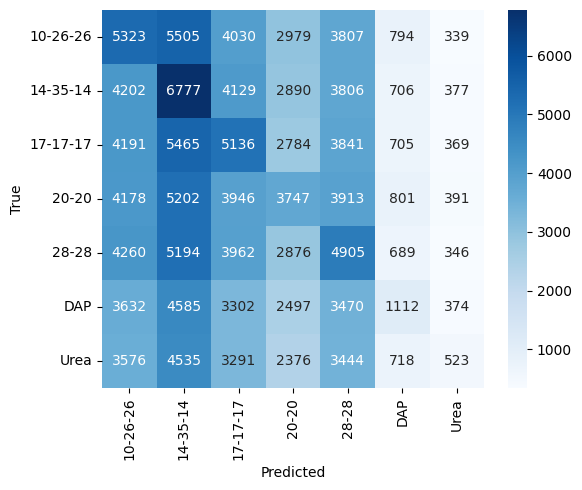

In [138]:
plot_confusion_matrix()

In [139]:
def plot_eager_confusion_matrix(test_y = test_y, top3_probs = top3_probs):
    y_true = [np.int64(x) for x in test_y.to_list()]
    y_pred = []
    for idx, ans in enumerate(y_true):
        flag = 0
        for pans in top3_probs[idx]:
            if pans == ans:
                y_pred.append(pans)
                flag = 1
                break
        if flag == 0:
            y_pred.append(top3_probs[idx][0])
    cmat = confusion_matrix(y_true, y_pred)
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, target_names = le.classes_))

    plt.figure(figsize = (6, 5))
    sns.heatmap(cmat, annot = True, fmt = 'd', xticklabels = le.classes_, yticklabels = le.classes_, cmap = "Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


Classification report:
              precision    recall  f1-score   support

    10-26-26       0.50      0.66      0.57     22777
    14-35-14       0.47      0.71      0.56     22887
    17-17-17       0.50      0.61      0.55     22491
       20-20       0.54      0.53      0.53     22178
       28-28       0.47      0.56      0.52     22232
         DAP       0.53      0.17      0.25     18972
        Urea       0.61      0.12      0.20     18463

    accuracy                           0.50    150000
   macro avg       0.52      0.48      0.45    150000
weighted avg       0.51      0.50      0.47    150000



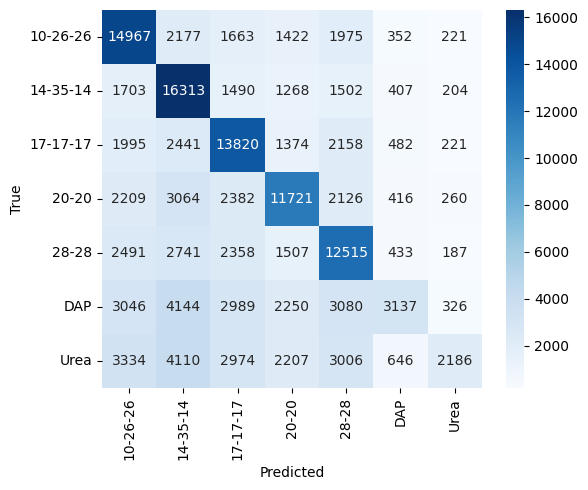

In [108]:
plot_eager_confusion_matrix()

## Observations:
- Some classes suffer from very low recall - `Urea` and `DAP` : this could be due to class imbalance in the training phase.
- No clear domination between classes in any instance for predictions, we need more EDA that is closer to features.

In [ ]:
## train a xgboost model with balanced split instead of stratified.

In [101]:
min_class_count = train_df[target_feature].value_counts().min()
balanced_df = train_df.groupby(target_feature).sample(n=min_class_count, random_state=42)
bfull_y, bfull_x = balanced_df[target_feature], balanced_df.drop(columns = [target_feature])
btrain_x, btest_x, btrain_y, btest_y = train_test_split(bfull_x, bfull_y, test_size = 0.2, random_state = 42, stratify = bfull_y)

In [102]:
model_b = XGBClassifier(
    objective = "multi:softprob",
    num_class = len(np.unique(btrain_y)),
    n_estimates = 1000,
    learning_rate = 0.045,
    max_depth = 7,
    colsmaple_bytree = 0.6,
    colsample_bylevel = 0.8,
    subsample = 0.8
)
model_b.fit(btrain_x, btrain_y)

/Users/abhishekmish/Documents/repos/kaggle_playground/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [15:43:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "colsmaple_bytree", "n_estimates" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.8, colsample_bynode=None,
              colsample_bytree=None, colsmaple_bytree=0.6, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.045, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimates=1000, n_estimators=None, ...)

In [109]:
## take last 3 and then sort by descending
by_pred_probs = model_b.predict_proba(btest_x)
# by_pred_probs.shape
btop3_probs = np.argsort(by_pred_probs, axis = 1)[:, -3:][:, ::-1]
btop3_probs.shape

(129244, 3)

In [140]:
get_best_and_full_accuracy_xgboost(test_y = btest_y, top3_probs = btop3_probs)

First accuracy: 0.18
Score accuracy: 0.31



Classification report:
              precision    recall  f1-score   support

    10-26-26       0.18      0.15      0.16     18463
    14-35-14       0.18      0.16      0.17     18463
    17-17-17       0.19      0.17      0.18     18463
       20-20       0.18      0.15      0.16     18464
       28-28       0.18      0.15      0.16     18464
         DAP       0.19      0.25      0.22     18463
        Urea       0.18      0.25      0.21     18464

    accuracy                           0.18    129244
   macro avg       0.18      0.18      0.18    129244
weighted avg       0.18      0.18      0.18    129244



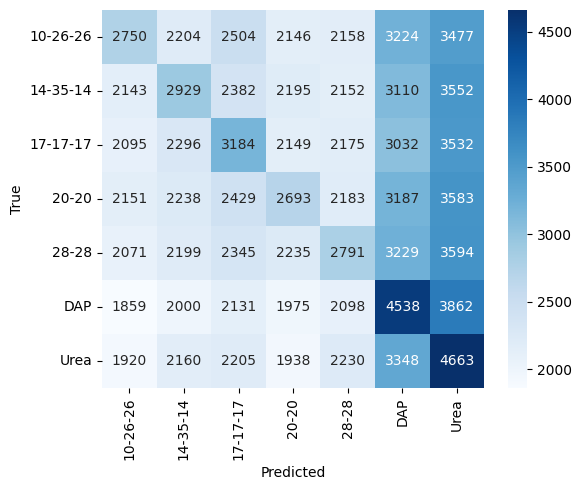

In [110]:
plot_confusion_matrix(test_y = btest_y, top3_probs = btop3_probs)


Classification report:
              precision    recall  f1-score   support

    10-26-26       0.53      0.45      0.49     18463
    14-35-14       0.53      0.51      0.52     18463
    17-17-17       0.51      0.49      0.50     18463
       20-20       0.52      0.45      0.48     18464
       28-28       0.53      0.49      0.51     18464
         DAP       0.45      0.53      0.49     18463
        Urea       0.43      0.55      0.48     18464

    accuracy                           0.49    129244
   macro avg       0.50      0.49      0.50    129244
weighted avg       0.50      0.49      0.50    129244



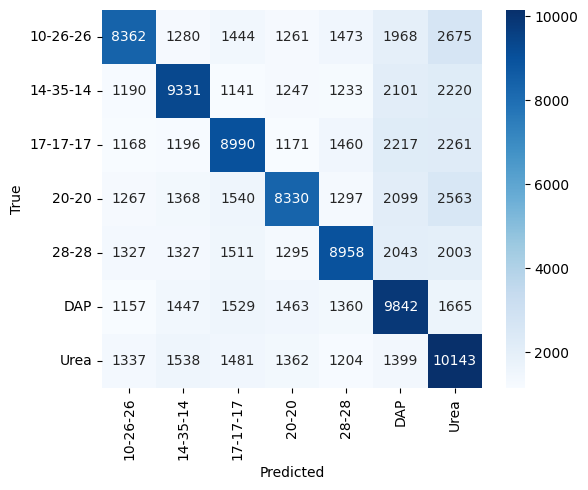

In [111]:
plot_eager_confusion_matrix(test_y = btest_y, top3_probs = btop3_probs)

In [114]:
## Target-wise and feature-specific KDE plots.
train_df[target_feature].value_counts()

Fertilizer Name
1    114436
0    113887
2    112453
4    111158
3    110889
5     94860
6     92317
Name: count, dtype: int64

In [115]:
le.classes_

array(['10-26-26', '14-35-14', '17-17-17', '20-20', '28-28', 'DAP',
       'Urea'], dtype=object)

In [118]:
def plot_kde(t1, t2, feature_name):
    sns.kdeplot(data = train_df[train_df[target_feature] == t1], x = feature_name, fill = True, label = le.classes_[t1])
    sns.kdeplot(data = train_df[train_df[target_feature] == t2], x = feature_name, fill = True, label = le.classes_[t2])
    plt.legend()
    plt.title(f"KDE of feature {feature_name} by target")
    plt.show()

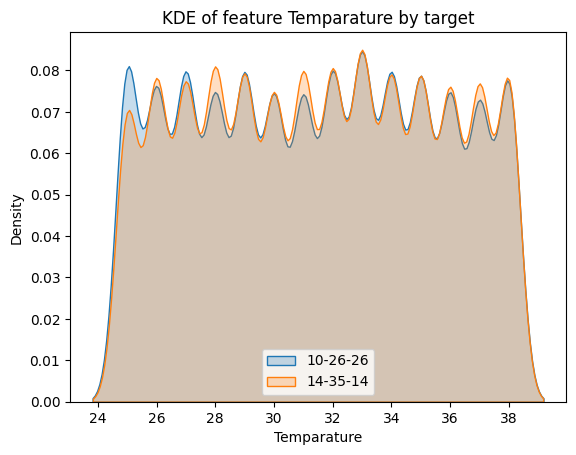

In [119]:
# for feature in numerical_features:
#     for i in range(len(le.classes_)):
#         for j in range(len(le.classes_)):
#             plot_kde(i, j, feature)
plot_kde(0, 1, numerical_features[0])

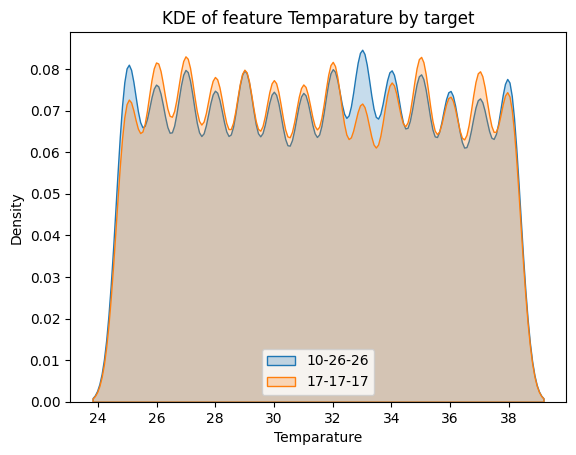

In [120]:
plot_kde(0, 2, numerical_features[0])

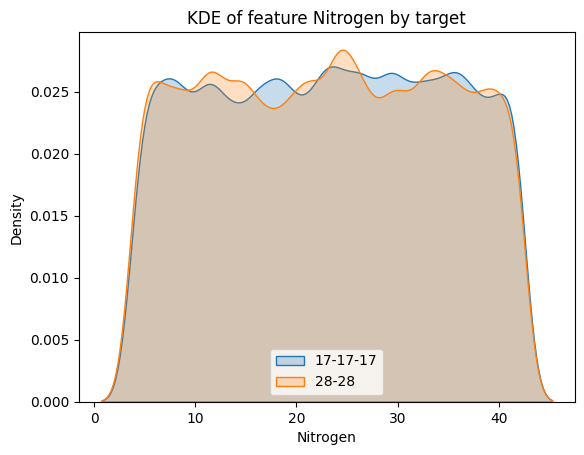

In [121]:
plot_kde(2, 4, numerical_features[3])

In [124]:
from scipy.stats import wasserstein_distance

def collate_wasserstein_distance(feature_name):
    matrix = np.zeros((len(le.classes_), len(le.classes_)))
    for i in range(len(le.classes_)):
        data_i = train_df[train_df[target_feature] == i][feature_name]
        for j in range(len(le.classes_)):
            data_j = train_df[train_df[target_feature] == j][feature_name]
            if j == i:
                continue
            distance_ij = wasserstein_distance(data_i, data_j)
            matrix[i][j] = distance_ij
            matrix[j][i] = distance_ij
    
    return pd.DataFrame(matrix, index = le.classes_, columns = le.classes_)

In [125]:
w1 = collate_wasserstein_distance(numerical_features[0])
w1.head(10)

,10-26-26,14-35-14,17-17-17,20-20,28-28,DAP,Urea
10-26-26,0.000000,0.072787,0.057261,0.057513,0.060077,0.054488,0.066652
14-35-14,0.072787,0.000000,0.084359,0.049806,0.059841,0.072837,0.053797
17-17-17,0.057261,0.084359,0.000000,0.055994,0.062671,0.064372,0.062377
20-20,0.057513,0.049806,0.055994,0.000000,0.044925,0.043655,0.032605
28-28,0.060077,0.059841,0.062671,0.044925,0.000000,0.032461,0.049804
DAP,0.054488,0.072837,0.064372,0.043655,0.032461,0.000000,0.052329
Urea,0.066652,0.053797,0.062377,0.032605,0.049804,0.052329,0.000000


In [126]:
w1 = collate_wasserstein_distance(numerical_features[1])
w1.head(10)

,10-26-26,14-35-14,17-17-17,20-20,28-28,DAP,Urea
10-26-26,0.000000,0.058483,0.100909,0.167187,0.102063,0.218660,0.203550
14-35-14,0.058483,0.000000,0.070715,0.141602,0.087228,0.193034,0.177858
17-17-17,0.100909,0.070715,0.000000,0.108432,0.115211,0.158812,0.141772
20-20,0.167187,0.141602,0.108432,0.000000,0.108277,0.068451,0.056334
28-28,0.102063,0.087228,0.115211,0.108277,0.000000,0.147287,0.132461
DAP,0.218660,0.193034,0.158812,0.068451,0.147287,0.000000,0.047055
Urea,0.203550,0.177858,0.141772,0.056334,0.132461,0.047055,0.000000


In [127]:
w1 = collate_wasserstein_distance(numerical_features[2])
w1.head(10)

,10-26-26,14-35-14,17-17-17,20-20,28-28,DAP,Urea
10-26-26,0.000000,0.100634,0.346428,0.242074,0.424441,0.212427,0.279378
14-35-14,0.100634,0.000000,0.359702,0.217374,0.400250,0.231439,0.249576
17-17-17,0.346428,0.359702,0.000000,0.576368,0.759952,0.537912,0.602398
20-20,0.242074,0.217374,0.576368,0.000000,0.191465,0.190727,0.131129
28-28,0.424441,0.400250,0.759952,0.191465,0.000000,0.270842,0.220365
DAP,0.212427,0.231439,0.537912,0.190727,0.270842,0.000000,0.230985
Urea,0.279378,0.249576,0.602398,0.131129,0.220365,0.230985,0.000000


In [130]:
w1 = collate_wasserstein_distance(numerical_features[3])
w1.head(10)

,10-26-26,14-35-14,17-17-17,20-20,28-28,DAP,Urea
10-26-26,0.000000,0.198798,0.085678,0.233624,0.198738,0.121588,0.239342
14-35-14,0.198798,0.000000,0.181281,0.216279,0.178752,0.230370,0.170629
17-17-17,0.085678,0.181281,0.000000,0.243527,0.191783,0.157813,0.234258
20-20,0.233624,0.216279,0.243527,0.000000,0.143342,0.198927,0.098105
28-28,0.198738,0.178752,0.191783,0.143342,0.000000,0.187413,0.124843
DAP,0.121588,0.230370,0.157813,0.198927,0.187413,0.000000,0.202688
Urea,0.239342,0.170629,0.234258,0.098105,0.124843,0.202688,0.000000


In [131]:
w1 = collate_wasserstein_distance(numerical_features[4])
w1.head(10)

,10-26-26,14-35-14,17-17-17,20-20,28-28,DAP,Urea
10-26-26,0.000000,0.100077,0.056631,0.069858,0.109224,0.302260,0.142468
14-35-14,0.100077,0.000000,0.073937,0.117637,0.056364,0.231690,0.084962
17-17-17,0.056631,0.073937,0.000000,0.084584,0.081796,0.271021,0.110585
20-20,0.069858,0.117637,0.084584,0.000000,0.130149,0.337451,0.180173
28-28,0.109224,0.056364,0.081796,0.130149,0.000000,0.225342,0.080296
DAP,0.302260,0.231690,0.271021,0.337451,0.225342,0.000000,0.164445
Urea,0.142468,0.084962,0.110585,0.180173,0.080296,0.164445,0.000000


In [132]:
w1 = collate_wasserstein_distance(numerical_features[5])
w1.head(10)

,10-26-26,14-35-14,17-17-17,20-20,28-28,DAP,Urea
10-26-26,0.000000,0.429336,0.137212,0.202930,0.136944,0.158211,0.153874
14-35-14,0.429336,0.000000,0.356287,0.300303,0.385400,0.454170,0.483555
17-17-17,0.137212,0.356287,0.000000,0.141907,0.133306,0.166971,0.186972
20-20,0.202930,0.300303,0.141907,0.000000,0.154416,0.158731,0.209880
28-28,0.136944,0.385400,0.133306,0.154416,0.000000,0.170342,0.165666
DAP,0.158211,0.454170,0.166971,0.158731,0.170342,0.000000,0.110533
Urea,0.153874,0.483555,0.186972,0.209880,0.165666,0.110533,0.000000


In [129]:
overall_was_distance = np.zeros((len(le.classes_), len(le.classes_)))
for feature in numerical_features:
    w = collate_wasserstein_distance(feature)
    overall_was_distance += w
overall_was_distance.head(10)

,10-26-26,14-35-14,17-17-17,20-20,28-28,DAP,Urea
10-26-26,0.000000,0.960115,0.784118,0.973186,1.031487,1.067635,1.085265
14-35-14,0.960115,0.000000,1.126281,1.043002,1.167835,1.413539,1.220377
17-17-17,0.784118,1.126281,0.000000,1.210812,1.344719,1.356900,1.338361
20-20,0.973186,1.043002,1.210812,0.000000,0.772573,0.997942,0.708226
28-28,1.031487,1.167835,1.344719,0.772573,0.000000,1.033687,0.773436
DAP,1.067635,1.413539,1.356900,0.997942,1.033687,0.000000,0.808035
Urea,1.085265,1.220377,1.338361,0.708226,0.773436,0.808035,0.000000
